In [6]:
!pip install transformers
!pip install pipeline
!pip install alpha_vantage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.1 MB/s eta 0:00:00


In [15]:
import requests
from transformers import pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [14]:
API_KEY_NEWS = '1b7347ce210b4f4b8e29100840049979'
MODEL_TYPE = 'distilbert-base-uncased-finetuned-sst-2-english'
STOCK_SYMBOL = 'GME'
START_DATE = '2020-01-01'
END_DATE = '2023-08-23'

In [16]:
#Defining functions

# Preprocessing
def preprocess_text(text):
    processed_text = text.lower().replace('-', ' ').replace('\n', ' ')
    return processed_text

# Fetch stock data using yfinance
def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

# Fetch news data using newsapi
def fetch_news_data(api_key):
    url = 'https://newsapi.org/v2/top-headlines'
    params = {
        'apiKey': api_key,
        'country': 'us',
        'category': 'business',
        'pageSize': 100
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data['articles']

In [18]:
# Create sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis', model=MODEL_TYPE)

# Import and preprocess news data
news_articles = fetch_news_data(API_KEY_NEWS)
for article in news_articles:
    article['processed_text'] = preprocess_text(article['title'])

# Perform sentiment analysis and augment news articles
for article in news_articles:
    sentiment = sentiment_analyzer(article['title'])
    article['sentiment_score'] = sentiment[0]['score']
    article['sentiment_label'] = sentiment[0]['label']

# Create a DataFrame for news articles
df = pd.DataFrame(news_articles)

# Preprocess text in news articles
df['processed_text'] = df['title'].apply(preprocess_text)

# Topic Modeling with Enhanced Parameters
vectorizer = CountVectorizer(max_df=0.85, max_features=1000, stop_words='english')
tf = vectorizer.fit_transform(df['processed_text'])
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
topics = lda_model.fit_transform(tf)
df['topic'] = topics.argmax(axis=1)

In [19]:
# Display Topics and Associated Words
topic_words = vectorizer.get_feature_names_out()
for i, topic_words_dist in enumerate(lda_model.components_):
    top_words_idx = topic_words_dist.argsort()[-10:][::-1]
    top_words = [topic_words[idx] for idx in top_words_idx]
    print(f"Topic {i + 1}: {', '.join(top_words)}")

Topic 1: cnbc, times, stocks, shares, guidance, starbucks, climate, money, weak, financial
Topic 2: journal, labor, reverse, cnn, techcrunch, financial, high, funds, fall, sales
Topic 3: san, new, news, barron, fox, francisco, louisville, diego, kitco, johnson
Topic 4: reuters, television, says, retail, com, forgerock, hill, norway, cnbc, announces
Topic 5: nvidia, cnbc, stock, bloomberg, market, street, wall, service, journal, earnings


In [20]:
# Display topics
print(df[['processed_text', 'sentiment_score', 'topic']])

                                       processed_text  sentiment_score  topic
0   stock market today: dow, s&p 500 rise ahead of...         0.998778      4
1   credit spreads are narrowing as the 10 year yi...         0.998020      3
2   lincoln's red way flight service to cease oper...         0.999262      4
3   peloton shares fall after posting wider than e...         0.999692      1
4   nvidia stock options traders are bracing for l...         0.973844      4
..                                                ...              ...    ...
63  vmware and nvidia unlock generative ai for ent...         0.992321      4
64  petrobras to continue producing oil for the ne...         0.830088      3
65  macy's revenue dips as in store, digital sales...         0.999350      4
66  amazon's radical plan for healthcare: à la car...         0.954845      2
67  how this vc evaluates generative ai startups  ...         0.965985      3

[68 rows x 3 columns]


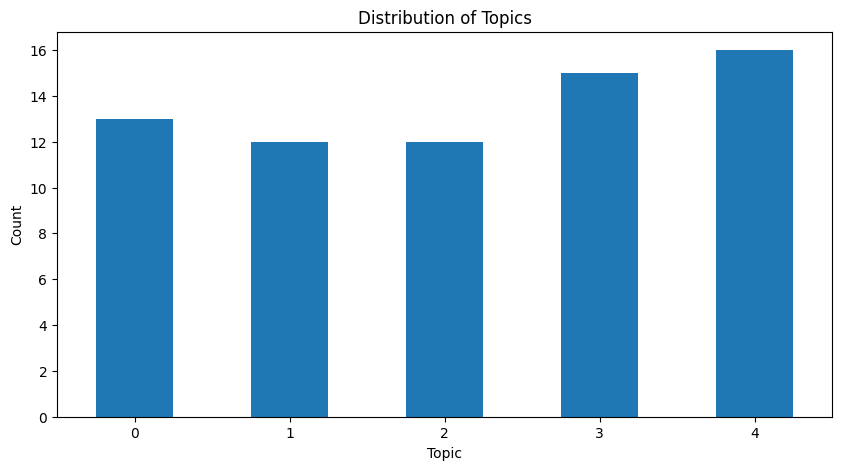

In [21]:
# Visualize Distribution of Topics
plt.figure(figsize=(10, 5))
df['topic'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Distribution of Topics')
plt.xticks(rotation=0)
plt.show()

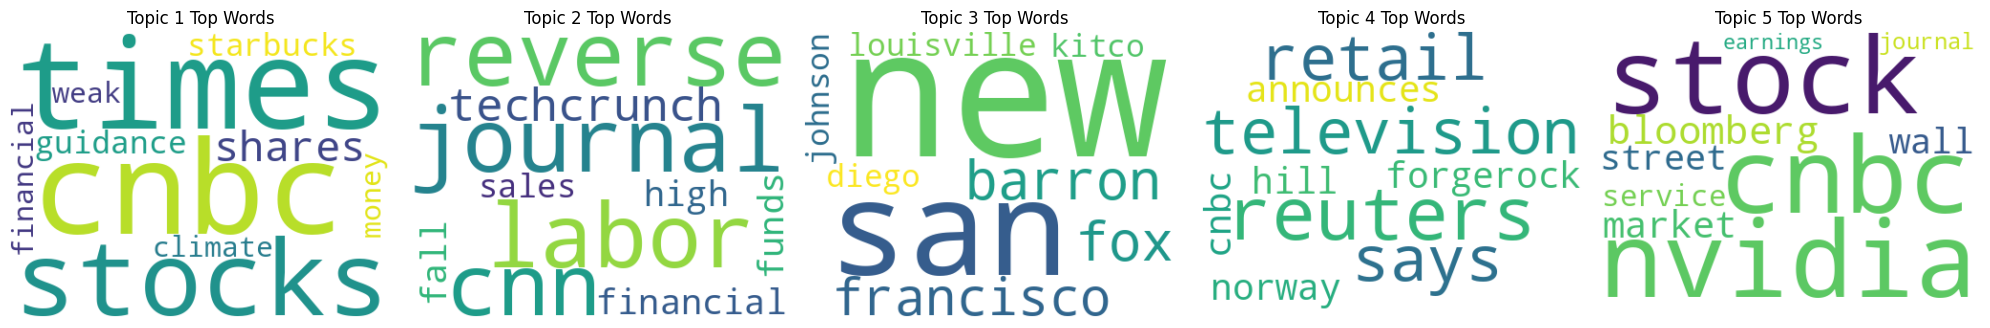

In [22]:
#Topic Word Cloud
fig, axes = plt.subplots(nrows=1, ncols=len(lda_model.components_), figsize=(20, 5))

for i, topic_words_dist in enumerate(lda_model.components_):
    top_words_idx = topic_words_dist.argsort()[-10:][::-1]
    top_words = [topic_words[idx] for idx in top_words_idx]
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(' '.join(top_words))

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Topic {i + 1} Top Words')

plt.tight_layout()
plt.show()